In [1]:
import numpy as np
import importlib.util
import matplotlib.pyplot as plt

import threading
# import torch

# if torch.cuda.is_available():  
#   dev = "cuda:1" 
# else:  
#   dev = "cpu"  

# device = torch.device(dev)

from simpleinfotheory import entropy

# from dp_laplace_mechanism import laplace_mechanism
 
# specify the module that needs to be
# imported relative to the path of the
# module
latent_load_module = importlib.util.spec_from_file_location("load_latent","/home/sjay9734/diff_encoder/face_privacy/face-privacy-diffae/utils/load_latent.py")
 
# creates a new module based on spec
latent_load = importlib.util.module_from_spec(latent_load_module)
 
# executes the module in its own namespace
# when a module is imported or reloaded.
latent_load_module.loader.exec_module(latent_load)

X_train, y_train, X_test, y_test = latent_load.pre_process_celebA(TRAINING_AMOUNT = 0.9)

In [10]:
!nvidia-smi

Thu Sep 21 19:01:39 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3080        Off | 00000000:01:00.0 Off |                  N/A |
| 30%   48C    P2             131W / 320W |   8142MiB / 10240MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
NO_BINS = 100
CLIP_ = 0

limit_ = []
for i in range(np.shape(X_train)[1]):
    min_val = np.min(X_train[:,i])
    max_val = np.max(X_train[:,i])

    limit_.append([min_val + CLIP_*abs(min_val), max_val - CLIP_*abs(max_val)])

def cal_hist(data, X_train, histograms, NO_BINS=NO_BINS, limit_=limit_, start_index = 0):
    no_axes = np.shape(data)[1]
    no_axes_x_train = np.shape(X_train)[1]

    for i in range(no_axes):
        for j in range(no_axes_x_train):
            H, _, _ = np.histogram2d(data[:, i], X_train[:, j], bins=NO_BINS, range=[[limit_[i + start_index][0], limit_[i + start_index][1]], [limit_[j][0], limit_[j][1]]], density=False)
            histograms.append(H)



In [3]:
NO_THREADS = 8 # make it power of 2

no_axes = np.shape(X_train)[1]
no_samples = np.shape(X_train)[0]
threads = []

value_range = []
i = 0
results = [[]]
for i in range(NO_THREADS-1):
    results.append([])
    value_range.append([(no_axes//NO_THREADS)*i, (no_axes//NO_THREADS)*(i+1)])
value_range.append([(no_axes//NO_THREADS)*(i+1), 512])

print(value_range)

# for i in range(NO_THREADS):
#     x = threading.Thread(target=cal_hist, args=(X_train[:,value_range[i][0]:value_range[i][1]], X_train, results[i], NO_BINS, limit_, value_range[i][0]))
#     threads.append(x)
#     x.start()

# for index, thread in enumerate(threads):
#     thread.join()

# print(len(results))

[[0, 64], [64, 128], [128, 192], [192, 256], [256, 320], [320, 384], [384, 448], [448, 512]]


In [4]:
# with open('hist_512.npy', 'wb') as f:
#     np.save(f, np.array(results, dtype = np.float32))

results = np.load('hist_512.npy')

In [40]:
# results = np.load('hist_512.npy')

In [5]:
laplace_mechanism_loader = importlib.util.spec_from_file_location("load_latent","/home/sjay9734/diff_encoder/face_privacy/face-privacy-diffae/privacy_mechanisms/dp_laplace_mechanism.py")
 
# creates a new module based on spec
laplace = importlib.util.module_from_spec(laplace_mechanism_loader)
 
# executes the module in its own namespace
# when a module is imported or reloaded.
laplace_mechanism_loader.loader.exec_module(laplace)

In [6]:
correlated_axes_list = [] # each sub list contain correlae]ted axis indexes

for i in results:
    index = 0
    print(len(i)%512)
    for j in range(len(i)//512):
        inner_correlated_list = []
        for k in range(512):
            # j /= no_samples # normalizing
            normalized_j = i[index]/no_samples
            # print(np.sum(normalized_j))
            dist_x = np.sum(normalized_j, axis = 0)
            dist_y = np.sum(normalized_j, axis = 1)
            flattern_dist = normalized_j.flatten()
            entropy_x = entropy(dist_x)
            entropy_y = entropy(dist_y)
            normalized_MI = (entropy_x + entropy_y - entropy(flattern_dist))/max(entropy_x, entropy_y)
            if normalized_MI > 0.01:
                inner_correlated_list.append(k)
            index += 1
        correlated_axes_list.append(inner_correlated_list)

        # fig, axs = plt.subplots(1, 1,
        #                               figsize =(5, 5),
        #                               tight_layout = True)
        # axs.hist(inner_correlated_list, bins = 100)

0


/share/home/sjay9734/diff_encoder/face_privacy/face-privacy-diffae/simpleinfotheory.py:23: RuntimeWarning: divide by zero encountered in log2
  return -np.log2(p)
/share/home/sjay9734/diff_encoder/face_privacy/face-privacy-diffae/simpleinfotheory.py:48: RuntimeWarning: invalid value encountered in multiply
  weightedShannonInfos = p*(infocontent(p))


0
0
0
0
0
0
0


In [7]:
def get_indexes_of_results_list(x_axis, y_axis):
    tot_count = x_axis*512 + y_axis
    count_in_sublist = 512*(no_axes//NO_THREADS)
    i = tot_count//count_in_sublist
    j = tot_count%count_in_sublist
    return i,j

In [81]:
# def guess_original_latent(perturbed_latent):
#     perturbed_latent = np.reshape(perturbed_latent, (512,))
#     guessed_laten = np.zeros(len(perturbed_latent))
#     for i in range(len(perturbed_latent)):
#         # print(np.shape(perturbed_latent))
#         correlated_axes_ = correlated_axes_list[i]
#         conditional_prob = np.zeros(NO_BINS)
#         for j in correlated_axes_:
#             j_axis_value = perturbed_latent[j]
#             # if j_axis_value > limit_[j][1] or j_axis_value < limit_[j][0]:
#             #     print("overflow", j_axis_value, limit_[j][0], limit_[j][1])
#             # else:
#             #     print("no overflow", j_axis_value, limit_[j][0], limit_[j][1])
#             j_axis_bin = int((j_axis_value - limit_[j][0])//(limit_[j][1]-limit_[j][0]))

#             if j_axis_bin >= NO_BINS:
#                 j_axis_bin = NO_BINS - 1
#             elif j_axis_bin < 0:
#                 j_axis_bin = 0
#             # print(j,i)
#             a,b = get_indexes_of_results_list(j, i)
#             # print(a, b, j_axis_bin)
#             marginal_prob = results[a][b][j_axis_bin,:]
#             conditional_prob += marginal_prob/np.sum(marginal_prob)
#         max_val_bin = np.argmax(conditional_prob)
#         max_value = (limit_[i][1]-limit_[i][0]) * max_val_bin + limit_[i][0]
#         guessed_laten[i] = max_value
#     return guessed_laten

In [8]:
# training dataset

LATENT_SIZE = 512
MAX_VARIANCE = 5

# specify the module that needs to be
# imported relative to the path of the
# module
# latent_load_module = importlib.util.spec_from_file_location("load_latent","/home/sjay9734/diff_encoder/face_privacy/face-privacy-diffae/utils/load_latent.py")
 
# creates a new module based on spec
# latent_load = importlib.util.module_from_spec(latent_load_module)
 
# executes the module in its own namespace
# when a module is imported or reloaded.
# latent_load_module.loader.exec_module(latent_load)

# X_train, y_train, X_test, y_test = latent_load.pre_process_celebA(TRAINING_AMOUNT = 0.9)

def create_dataset(axis = 0):
    i = 0
    train_X_list = []
    train_y_list = []

    for i in range(LATENT_SIZE):
        train_y_list.append([])

    while i < (20000):
        
        if np.random.randint(2, size=1) == 1:
            train_X_list.append(X_train[i])
            for 
            train_y_list[axis].append(X_train[i][axis])
            i += 1
        else:
            random_index = np.random.randint(len(X_train), size=1)
            gaussian_noise = np.random.normal(loc=0.0, 
                                            scale=np.random.randint(MAX_VARIANCE, size=1), size=LATENT_SIZE)
            train_X_list.append(np.reshape(X_train[random_index] + gaussian_noise, (LATENT_SIZE)))
            train_y_list[axis].append(X_train[random_index][axis])
            
    augmented_train_X = np.array(train_X_list)
    augmented_train_y = np.array(train_y_list)

    return augmented_train_X, augmented_train_y

In [9]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
model_list = []

for i in range(LATENT_SIZE):
    input_data, target_data = create_dataset(i)
    
    model = MLPRegressor(hidden_layer_sizes=(32, 16), activation='relu', solver='adam', max_iter=10000)

    # Train the model on the training data
    model.fit(input_data, target_data)

    # Make predictions on the test data
    # y_pred = model.predict(X_test)
    model_list.append(model)
    print("Axis ", i)

Axis  0
Axis  1
Axis  2
Axis  3
Axis  4
Axis  5
Axis  6
Axis  7
Axis  8
Axis  9
Axis  10
Axis  11
Axis  12
Axis  13
Axis  14
Axis  15
Axis  16
Axis  17
Axis  18
Axis  19
Axis  20


/home/sjay9734/diff_encoder/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


Axis  21
Axis  22
Axis  23
Axis  24
Axis  25
Axis  26
Axis  27
Axis  28


In [ ]:
def guess_original_latent(perturbed_latent):
    guessed_latent = np.zeros(LATENT_SIZE)
    for i in range(LATENT_SIZE):
        guessed_latent[i] = model_list[i].predict(np.reshape(perturbed_latent, (1,-2)))
    
    return guessed_latent

In [45]:
sensitivity_arr = []

for i in range(512):
    sensitivity_arr.append(laplace.local_sensitivity(X_train[:,i], 0.1))

laplace_construct = laplace.laplace_mechanism(1)

In [46]:
# DP with laplace

def dp_latent(latent, eps):
    perturbed_latent = np.zeros(512)
    for i in range(512):
        perturbed_latent[i] = laplace_construct.gen_random_output(latent[i], eps, sensitivity_arr[i])
    
    return perturbed_latent

In [84]:
EPS = 1

for i in range(10):
    perturbed_latent = dp_latent(X_train[i], EPS)
    guess_latent = guess_original_latent(perturbed_latent)

    perturbed_l2 = np.linalg.norm(perturbed_latent - X_test[i])
    guessed_l2 = np.linalg.norm(guess_latent - X_test[i])

    print("perturbed_l2 ", perturbed_l2, " guessed_l2 ", guessed_l2)

/tmp/ipykernel_3064231/4249545442.py:24: RuntimeWarning: divide by zero encountered in divide
  conditional_prob += marginal_prob/np.sum(marginal_prob)
/tmp/ipykernel_3064231/4249545442.py:24: RuntimeWarning: invalid value encountered in divide
  conditional_prob += marginal_prob/np.sum(marginal_prob)


perturbed_l2  24.770771843054582  guessed_l2  149.60466376472053
perturbed_l2  22.647597110697767  guessed_l2  161.425142448833
perturbed_l2  23.79085009474736  guessed_l2  132.31247852175275
perturbed_l2  24.748703010773188  guessed_l2  145.20085196211912
perturbed_l2  21.67550236810693  guessed_l2  148.5098539552892
perturbed_l2  23.643547298976454  guessed_l2  175.21131780597568
perturbed_l2  24.369955500647023  guessed_l2  127.56731808391443
perturbed_l2  24.511649336903044  guessed_l2  201.5511552406742
perturbed_l2  25.57335717088519  guessed_l2  114.61344763532493
perturbed_l2  24.683597852891488  guessed_l2  195.32022395075757


In [85]:
from templates import *
from templates_cls import *
from experiment_classifier import ClsModel

In [86]:
device = 'cuda:3'
conf = ffhq256_autoenc()
# print(conf.name)
model = LitModel(conf)
state = torch.load(f'/home/sjay9734/diff_encoder/face_privacy/face-privacy-diffae/checkpoints/{conf.name}/last.ckpt', map_location='cpu')
model.load_state_dict(state['state_dict'], strict=False)
model.ema_model.eval()
model.ema_model.to(device);

Global seed set to 0


Model params: 160.69 M


In [87]:
cls_conf = ffhq256_autoenc_cls()
cls_model = ClsModel(cls_conf)
state = torch.load(f'/home/sjay9734/diff_encoder/face_privacy/face-privacy-diffae/checkpoints/{cls_conf.name}/last.ckpt',
                    map_location='cpu')
print('latent step:', state['global_step'])
cls_model.load_state_dict(state['state_dict'], strict=False);
cls_model.to(device);

Global seed set to 0


loading pretrain ... 130M
step: 1563562
loading latent stats ...
latent step: 9375


In [51]:
data = ImageDataset('imgs_align', image_size=conf.img_size, exts=['jpg', 'JPG', 'png'], do_augment=False)
batch = data[2]['img'][None]

In [52]:
cond = model.encode(batch.to(device))
xT = model.encode_stochastic(batch.to(device), cond, T=250)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


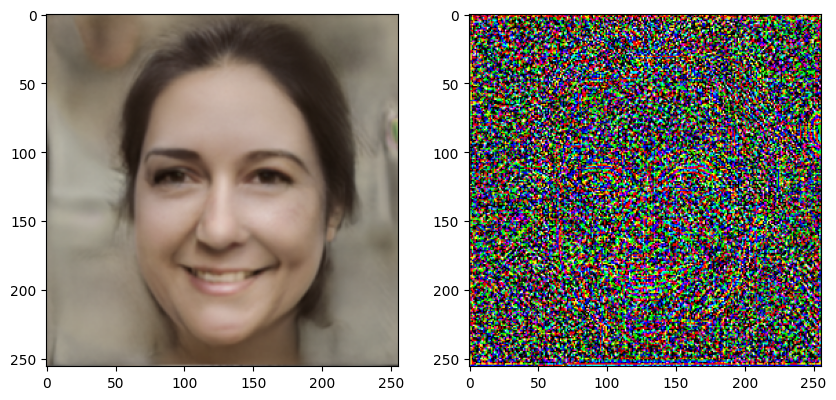

In [88]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ori = (batch + 1) / 2
ax[0].imshow(ori[0].permute(1, 2, 0).cpu())
ax[1].imshow(xT[0].permute(1, 2, 0).cpu())

In [89]:
cls_id = CelebAttrDataset.cls_to_id['Wavy_Hair']
cond2 = cls_model.normalize(cond)
cond2 = cond2 + 0.3 * math.sqrt(512) * F.normalize(cls_model.classifier.weight[cls_id][None, :], dim=1)
cond2 = cls_model.denormalize(cond2)

In [55]:
cond


tensor([[-1.2404e-01, -5.8368e-02,  3.0108e-02,  6.1065e-02, -2.3773e-02,
         -2.7477e-02,  6.4068e-02, -1.6492e-01,  2.5765e-02, -1.6490e-01,
          3.9936e-02, -1.4003e+00,  4.5021e-02, -4.2993e-02,  7.0958e-02,
          4.3981e-02, -3.8350e-03,  4.0697e-02, -9.2761e-02,  9.2445e-02,
         -7.4355e-02,  2.5556e-02, -1.9448e-02,  7.7040e-02,  7.1759e-02,
         -1.0826e-01, -2.9249e-01,  3.0929e-02,  3.0546e-02,  3.0964e-02,
          3.1243e-03,  7.8715e-02,  7.3076e-02, -8.5405e-02, -6.0517e-02,
          1.4881e-02,  2.0522e-01, -2.7118e-02,  1.0524e+00, -1.0616e-01,
         -1.2003e-02, -4.6942e-02, -8.7917e-02,  1.7573e-01,  5.4782e-02,
          8.2255e-02,  7.5295e-02, -1.7034e+00, -8.5472e-02,  1.3342e-01,
          9.2779e-02,  5.0482e-02,  4.3417e-02, -1.0949e-02, -2.4236e-02,
          5.0179e-02,  2.1053e-01,  1.4891e-01,  1.1970e-01,  2.2429e-02,
          6.7857e-02,  7.2987e-02, -1.0630e-01,  1.9355e-03,  3.0037e-01,
          2.5326e-02, -7.1646e-02, -2.

In [102]:
new_ = np.reshape((X_test[10]), (1,512))


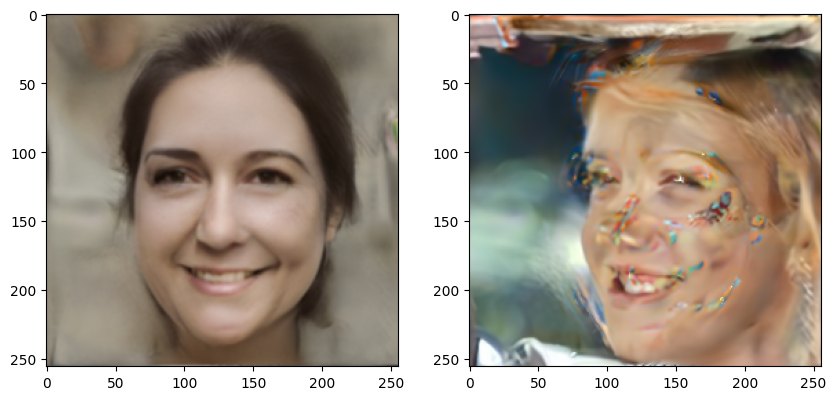

In [104]:
import matplotlib.pyplot as plt
# torch.manual_seed(1)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
img = model.render(xT, (torch.from_numpy(new_).type(torch.float32).to(device)), T=100) #cond2, T=100)
ori = (batch + 1) / 2
ax[0].imshow(ori[0].permute(1, 2, 0).cpu())
ax[1].imshow(img[0].permute(1, 2, 0).cpu())
plt.savefig('imgs_manipulated/compare.png')

In [ ]:
# training dataset

LATENT_SIZE = 512
MAX_VARIANCE = 5

# specify the module that needs to be
# imported relative to the path of the
# module
# latent_load_module = importlib.util.spec_from_file_location("load_latent","/home/sjay9734/diff_encoder/face_privacy/face-privacy-diffae/utils/load_latent.py")
 
# creates a new module based on spec
# latent_load = importlib.util.module_from_spec(latent_load_module)
 
# executes the module in its own namespace
# when a module is imported or reloaded.
# latent_load_module.loader.exec_module(latent_load)

# X_train, y_train, X_test, y_test = latent_load.pre_process_celebA(TRAINING_AMOUNT = 0.9)

def create_dataset(axis = 0):
    i = 0
    train_X_list = []
    train_y_list = []

    for i in range(LATENT_SIZE):
        train_y_list.append([])

    while i < (20000):
        
        if np.random.randint(2, size=1) == 1:
            train_X_list.append(X_train[i])
            for 
            train_y_list[axis].append(X_train[i][axis])
            i += 1
        else:
            random_index = np.random.randint(len(X_train), size=1)
            gaussian_noise = np.random.normal(loc=0.0, 
                                            scale=np.random.randint(MAX_VARIANCE, size=1), size=LATENT_SIZE)
            train_X_list.append(np.reshape(X_train[random_index] + gaussian_noise, (LATENT_SIZE)))
            train_y_list[axis].append(X_train[random_index][axis])
            
    augmented_train_X = np.array(train_X_list)
    augmented_train_y = np.array(train_y_list)

    return augmented_train_X, augmented_train_y